In [34]:
import yaml
import torch
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
import pandas as pd
from omegaconf import OmegaConf
import scanpy as sc

import numpy as np
import IMPA.featurizer.vision_transformer as vits
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import pickle as pkl

**Plotting function**

In [2]:
def pca_umap_plot_with_preprocessing(adata, title, batch_name):
    # Set a random seed for reproducibility
    np.random.seed(0)

    # Randomly permute the indices
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    # Set a color palette for better color representation
    sns.set_palette("tab10")

    # Plot the PCA with random reordering
    sc.pl.pca(adata[random_indices, :], color=batch_name, title=title, s=20)

    # Plot the UMAP with random reordering
    # sc.pl.umap(adata[random_indices, :], color=batch_name, title=title, s=20)
    sc.pl.umap(adata, color=batch_name, title=title, s=20)

    # Show the plots
    plt.show()

**Code**

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

From https://github.com/broadinstitute/DINO4Cells_code

In [4]:
path_to_config = "/home/icb/alessandro.palma/environment/IMPA/IMPA/configs/config_dino.yaml"
config = yaml.safe_load(open(path_to_config, "r"))

In [5]:
ckpt_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_base_checkpoint.pth"

In [6]:
state_dict = torch.load(ckpt_path)

**Load model weights**

In [7]:
config["model"]["arch"]

'vit_base'

In [8]:
model = vits.__dict__[config["model"]["arch"]](
                img_size=[128],
                patch_size=16,
                in_chans=5
            )

embed_dim = model.embed_dim

In [57]:
config["embedding"]["HEAD"] = (
        True if "HEAD" in list(config["embedding"].keys()) else False
    )

In [58]:
embed_dim

768

In [59]:
for p in model.parameters():
    p.requires_grad = False

In [60]:
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [61]:
pretrained_weights = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/Cell_Painting_data/DINO_cell_painting_small_checkpoint.pth"

In [62]:
state_dict = torch.load(pretrained_weights)

In [63]:
if "teacher" in state_dict:
    teacher = state_dict["teacher"]
    if not config["embedding"]["HEAD"] == True:
        teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
        teacher = {
            k.replace("backbone.", ""): v for k, v in teacher.items()
        }
    msg = model.load_state_dict(teacher, strict=False)
else:
    student = state_dict
    if not config["embedding"]["HEAD"] == True:
        student = {k.replace("module.", ""): v for k, v in student.items()}
        student = {
            k.replace("backbone.", ""): v for k, v in student.items()
        }
    student = {k.replace("0.", ""): v for k, v in student.items()}
    msg = model.load_state_dict(student, strict=False)

In [64]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

**Featurize cells**

In [65]:
img = torch.randn(16, 5, 96, 96).cuda()

In [66]:
feat = model(img)

In [67]:
feat.shape

torch.Size([16, 768])

**Featurize RxRx1 before and after batchn transformation**

In [87]:
args = {
    "task_name": "cpg0000_batch",
    "img_size": 96,
    "latent_dim": 100,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 10,
    "dim_in": 64,
    "pert_modelling": False,
    "batch_key": "PLATE",
    "subsample_frac": 0.05,
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,
    "total_epochs": 20,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": None,
    "mol_list": None,
    "balanced": False,
    "trainable_emb": True,
    "dataset_name": "cpg0000",
    "n_channels": 5,
    "num_workers": 8,
    "seed": 42,
    "image_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large",
    "data_index_path": "/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large.csv",
    "embedding_path": None,
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",
    "checkpoint_dir": "checkpoint",
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/",
    "augment_train": True,
    "normalize": True,
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "cpg0000_batch",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}
args = OmegaConf.create(args)

In [88]:
dataloader = CellDataLoader(args)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [89]:
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch"

In [90]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(20)

Number of parameters in generator: 24319877
Number of parameters in style_encoder: 14330624
Number of parameters in discriminator: 14302922
Number of parameters in mapping_network: 7104
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/checkpoint/000020_nets.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/checkpoint/000020_nets.ckpt
Loading checkpoint from /home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b05ba74dfcc6_cpg0000_batch/checkpoint/000020_embeddings.ckpt...
/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240101_348bb3f1-6a5b-47f2-9388-b0

In [91]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [92]:
X_before_transf = []
X_after_transf = []

features = {"plate": [],
            "well": [],
            "view": [],
            "no": []}

In [ ]:
# Transform all with the same random vector. Take the mean 
z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for loader in [train_dataloader, val_dataloader]:
        for batch in tqdm(loader):
            # # Get image 
            X = batch["X"].cuda()
            z = z_common.repeat(X.shape[0], 1)
            # Transport everything to a chosen batch, here we pick 0
            y = 0*torch.ones(X.shape[0]).long().cuda()
            y = solver.embedding_matrix(y).cuda()
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
            # Transport image to new batch
            _, X_generated = solver.nets.generator(X, y)
            for i, filename in enumerate(batch["file_names"]):
                plate, well, view, no = filename.split("-")[0].split("_")
                features["plate"].append(plate)
                features["well"].append(well)
                features["view"].append(view)
                features["no"].append(no)

            Z_before_transf = model(X)
            Z_after_transf = model(X_generated)

            X_before_transf.append(Z_before_transf.detach().cpu())
            X_after_transf.append(Z_after_transf.detach().cpu())

In [94]:
X_before_transf = torch.cat(X_before_transf, dim=0)
X_after_transf = torch.cat(X_after_transf, dim=0)

In [99]:
adata_before_transf = sc.AnnData(X=X_before_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))
adata_after_transf = sc.AnnData(X=X_after_transf.detach().cpu().numpy(), 
                                 obs= pd.DataFrame(features))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Before correction

In [100]:
# sc.tl.pca(adata_before_transf)
# sc.pp.neighbors(adata_before_transf)
# sc.tl.umap(adata_before_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/

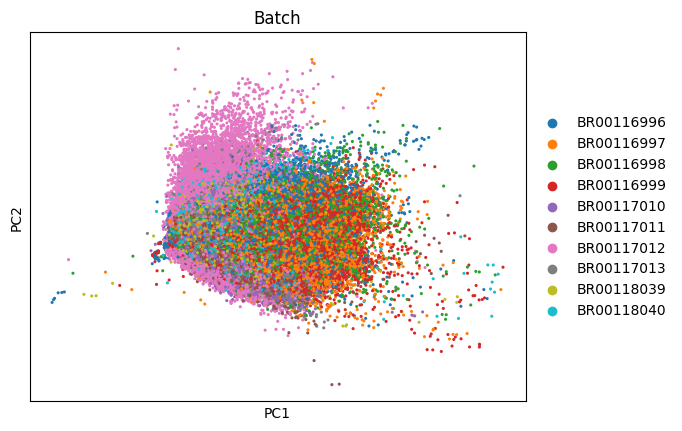

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


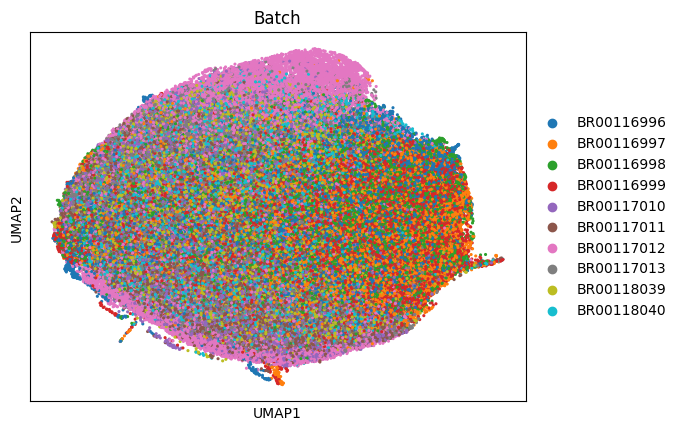

In [108]:
pca_umap_plot_with_preprocessing(adata_before_transf, "Batch", "plate")

After correction

In [109]:
# sc.tl.pca(adata_after_transf)
# sc.pp.neighbors(adata_after_transf)
# sc.tl.umap(adata_after_transf)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/

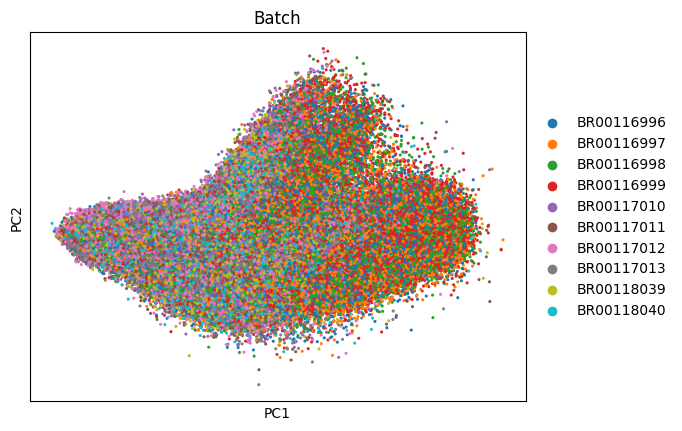

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


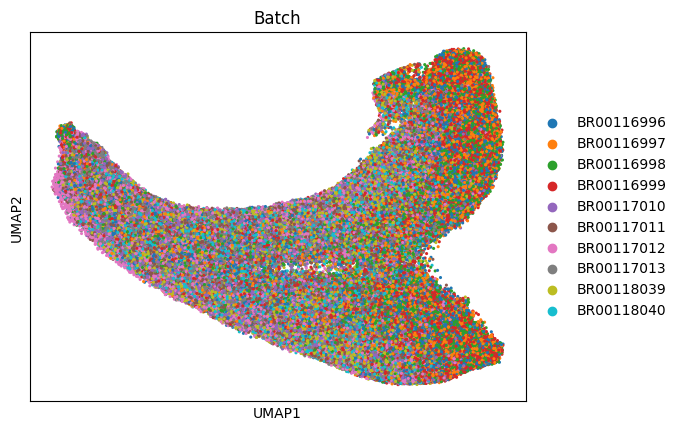

In [110]:
pca_umap_plot_with_preprocessing(adata_after_transf, "Batch", "plate")

Save results

In [12]:
feature_dest_folder = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata")

In [13]:
# adata_before_transf.write_h5ad(feature_dest_folder / "cpg0000_adata_before_transf.h5ad")

In [14]:
# adata_after_transf.write_h5ad(feature_dest_folder / "cpg0000_adata_after_transf.h5ad")

In [36]:
adata_before_transf = sc.read_h5ad(feature_dest_folder / "cpg0000_adata_before_transf.h5ad")

In [37]:
adata_after_transf = sc.read_h5ad(feature_dest_folder / "cpg0000_adata_after_transf.h5ad")

## Add compounds to AnnData

In [38]:
data_index = pd.read_csv('/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large.csv', index_col=1)
data_index

,Unnamed: 0,PLATE,WELL,PERT_TYPE,CPD_NAME,STATE,ANNOT,GENE,SEQUENCE,SPLIT
SAMPLE_KEY,,,,,,,,,,
BR00117010_M01_9_144,0,BR00117010,M01,Compound,DMSO,control,Compound,none,CS(=O)C,train
BR00116999_L03_6_93,1,BR00116999,L03,CRISPR,HTR2C,trt,CRISPR,HTR2C,GTTACTGCACGGCCACACCG,test
BR00116997_C07_7_109,2,BR00116997,C07,CRISPR,CYP2A6,trt,CRISPR,CYP2A6,GTTTCCAATGAAGGGCAATG,train
BR00116998_O24_1_69,3,BR00116998,O24,CRISPR,ADA,trt,CRISPR,ADA,CACAGACTGGTCCCCCAAGG,test
BR00117011_A19_8_13,4,BR00117011,A19,Compound,flupirtine,trt,Compound,KCNQ2,CCOC(=O)Nc1ccc(NCc2ccc(F)cc2)nc1N,test
...,...,...,...,...,...,...,...,...,...,...
BR00116999_I05_5_206,435156,BR00116999,I05,CRISPR,none,control,CRISPR,none,TCGATCGAGGTTGCATTCGG,train
BR00116997_F02_6_125,435157,BR00116997,F02,CRISPR,none,control,CRISPR,none,TTTACGATCTAGCGGCGTAG,train
BR00116997_M09_7_26,435158,BR00116997,M09,CRISPR,none,control,CRISPR,none,CTTACAATCGTCGGTCCAAT,train


In [39]:
# feature_df = pd.DataFrame(features)

In [40]:
compound_names = []

for row in adata_before_transf.obs.iterrows():
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)

In [41]:
adata_before_transf.obs["compound"] = compound_names

In [42]:
adata_after_transf.obs["compound"] = compound_names

## Evaluate scIB metrics

In [43]:
adata_unique = adata_before_transf.copy()

In [44]:
adata_unique.obsm["Unintegrated"] = adata_before_transf.obsm["X_pca"]

In [45]:
adata_unique.obsm["IMPA-Integrated"] = adata_after_transf.obsm["X_pca"]

In [46]:
from scib_metrics.benchmark import Benchmarker

In [ ]:
bm = Benchmarker(
    adata_unique,
    batch_key="plate",
    label_key="compound",
    embedding_obsm_keys=["Unintegrated", "IMPA-Integrated"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

In [ ]:
scib_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/scib/cpg0000.pkl"

In [ ]:
with open(scib_path, "wb") as file:
    pkl.dump(bm, file)